In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [4]:

voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/breast_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [5]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                            #    baseline = (1500, 1000),
                               baseline = (1440, 1000),
                               seed = None,
                               )

skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=1)
coupling = tissue.Tissue(name='coupling', c=1440, rho=911, sigma=0, scale=0.00001, label=7)
# skin = tissue.Tissue(name='skin', c=1500, rho=1000, sigma=0, scale=0.00001, label=1)
fat = tissue.Tissue(name='fat', c=1440, rho=911, sigma=40, scale=0.0003, label=2)
# fat = tissue.Tissue(name='fat', c=1440, rho=911, sigma=20, scale=0.0003, label=2)
ligament = tissue.Tissue(name='ligament', c=1750, rho=1142, sigma=30, scale=0.0001, label=3)
gland = tissue.Tissue(name='gland', c=1564, rho=1041, sigma=40, scale=0.0002, label=4)
# tumor = tissue.Tissue(name='tumor', c=1550, rho=1050, sigma=0, scale=0.0001, label=5)
tumor = tissue.Tissue(name='tumor', c=1560, rho=1050, sigma=0, scale=0.001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)

kidney_file_dir = f"{parent}/assets/breast_phantom/"
kidney_tissue_list = [skin, fat, skin, gland, gland, ligament, muscle, tumor]
test_phantom.add_tissue(coupling)
test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
# test_phantom.set_default_tissue('water')
test_phantom.set_default_tissue('coupling')

Added skin
Added fat
Added skin
Added gland
Added gland
Added ligament
Added muscle
Added tumor


In [6]:
test = test_phantom.get_complete()

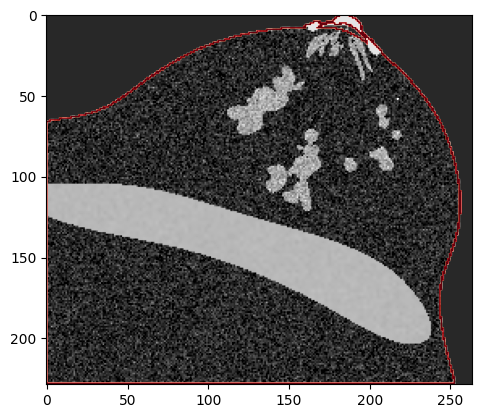

In [38]:
index = 110
plt.imshow(test[0, :, :, index], cmap='gray', vmin=1400, vmax=1650)
plt.imshow(body_mask[:,:, index] * 1000, alpha=0.5*(body_mask[:,:, index]>0)*2, cmap='Reds')

# Set up simulation

In [39]:
# num_transducers = 8192
# num_transducers = 1024
# transducers = [transducer.Focused(max_frequency=0.75e6,
#                                     elements = 1, 
#                                     width = 2e-3,
#                                     height =  2e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = (0,0),
#                                     ray_num = (1,1),
#                                     imaging_ndims = 3,
#                                     focus_azimuth = float('inf'),
#                                     focus_elevation = float('inf'),
#                                     source_strength = 1e7,
#                                     cycles = 2,
#                                     ) for i in range(num_transducers)]

num_transducers = 8192
transducers = [transducer.Focused(max_frequency=1e6,
                                    elements = 1, 
                                    width = 2e-3,
                                    height =  2e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = (0,0),
                                    ray_num = (1,1),
                                    imaging_ndims = 3,
                                    focus_azimuth = float('inf'),
                                    focus_elevation = float('inf'),
                                    source_strength = 1e7,
                                    cycles = 1,
                                    transmit = i%21==0,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [40]:
import math

def fibonacci_sphere(samples=1000, maxphi=2*np.pi):
    coords = []
    angles = []
    phi = math.pi * (math.sqrt(5.) - 1.)
    for i in range(samples):
        x = 1 - (i / float(samples - 1)) * 2  * maxphi / (2 * np.pi)
        radius = math.sqrt(1 - x * x)
        theta = phi * i
        y = math.cos(theta) * radius
        z = math.sin(theta) * radius
        coords.append((x, y, z))
        angles.append((math.acos(x), -np.pi, theta % (np.pi * 2) - np.pi))
    return np.array(coords), np.array(angles)

In [41]:
global_transform = geometry.Transform([np.pi * 0.87,np.pi * -0.05,0],[-0.00,0.005,-0.01], intrinsic=False)
coords, angles = fibonacci_sphere(num_transducers, maxphi=np.pi/2)

for i,(coord,angle) in enumerate(zip(coords, angles)):
    test_transducer_set.assign_pose(i, global_transform * geometry.Transform(angle, global_transform.apply_to_point(coord) * 0.07, intrinsic=False))

In [42]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

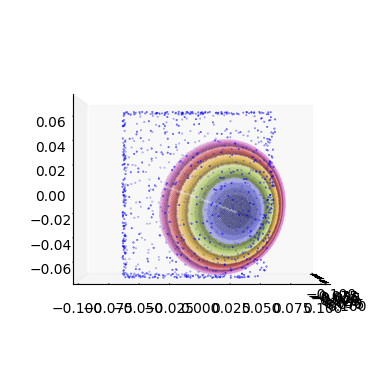

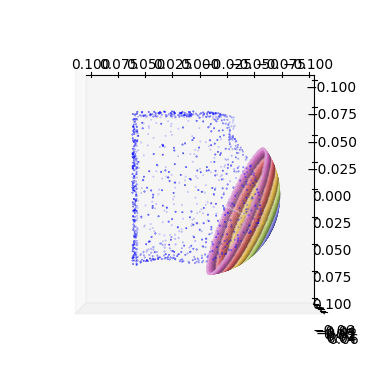

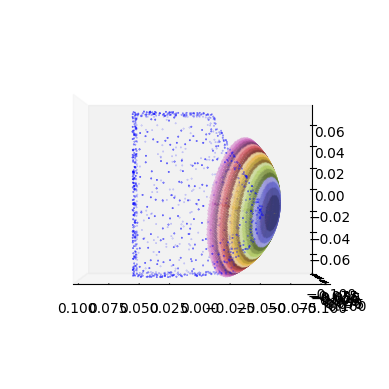

In [44]:
points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/00_breast_single_VH_F_skin.obj")).sample_points_uniformly(1000).points)
points = points[:,[0,1,2]] - np.array(((np.amax(np.array(surface_mesh.vertices)[:,0]) + np.amin(np.array(surface_mesh.vertices)[:,0])) / 2,
                                       (np.amax(np.array(surface_mesh.vertices)[:,1]) + np.amin(np.array(surface_mesh.vertices)[:,1])) / 2,
                                       (np.amax(np.array(surface_mesh.vertices)[:,2]) + np.amin(np.array(surface_mesh.vertices)[:,2])) * -2))

test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(0,0))
test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(90,90))
test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(0,90))

In [45]:
simprops = simulation.SimProperties(
                grid_size   = (100e-3,100e-3,100e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [47]:
# test_experiment = experiment.Experiment(
#                  simulation_path = 'breast_3D_planewave_net',
#                  sim_properties  = simprops,
#                  phantom         = test_phantom,
#                  transducer_set  = test_transducer_set,
#                  sensor          = test_sensor,
#                  nodes           = 1,
#                  results         = None,
#                  indices         = None,
#                  workers         = 3,
#                  additional_keys = ['p_max_all']
#                  )

test_experiment = experiment.Experiment(
                 simulation_path = 'breast_synthetic_aperture_2',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [16]:
# utils.save_mrc(test_experiment.get_sensor_mask(pad=50), 'breast_tomography_sensor_mask.mrc')

In [17]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

In [18]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), 180, slice(0, -1, 1)])

In [19]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

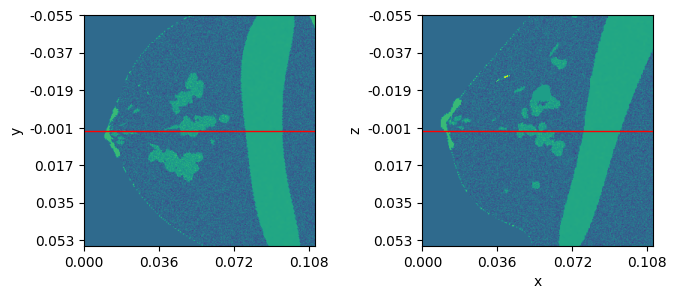

In [48]:
test_experiment.plot_ray_path(0)

In [21]:
# test_experiment.plot_ray_path(4095)

# Run Simulation

In [7]:
test_experiment = experiment.Experiment.load('breast_synthetic_aperture_2')
test_experiment.run(dry=True, dry_fast=True)

Number of simulation results (286) is less than the expected number of simulation results (391), are you sure the simulation finished running?
dry run of simulation
Fast dry runs only works when all transducers are identical, use dry_fast=False if your transducers differ from each other


100%|██████████| 8192/8192 [00:00<00:00, 1905381.15it/s]


In [3]:
test_experiment.run(repeat=False)

running with 3 workers

preparation for sim   80 completed in 61.76 seconds
preparation for sim  276 completed in 62.53 seconds
preparation for sim   81 completed in 70.24 seconds
preparation for sim  277 completed in 70.15 seconds
simulation            80 completed in 117.45 seconds
simulation           276 completed in 109.19 seconds
preparation for sim  278 completed in 98.39 seconds
preparation for sim   82 completed in 100.01 seconds
simulation            81 completed in 166.84 seconds
simulation           277 completed in 104.57 seconds
preparation for sim  279 completed in 67.86 seconds
preparation for sim   83 completed in 75.07 seconds
simulation            82 completed in 114.86 seconds
simulation           278 completed in 142.92 seconds
preparation for sim   84 completed in 71.52 seconds
preparation for sim  280 completed in 71.09 seconds
simulation            83 completed in 114.27 seconds
simulation           279 completed in 103.46 seconds
preparation for sim  281 comple

# Reconstruction

In [3]:
test_experiment = experiment.Experiment.load('breast_synthetic_aperture')
# test_experiment = experiment.Experiment.load('recon_testing')
test_experiment.run(dry=True, workers=8, dry_fast=True)
test_experiment.add_results()

dry run of simulation
Fast dry runs only works when all transducers are identical, use dry_fast=False if your transducers differ from each other


100%|██████████| 8192/8192 [00:00<00:00, 1950927.68it/s]


In [ ]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [ ]:
images2 = test_reconstruction.compound(workers=16, resolution_multiplier=1, combine=False, volumetric=True, attenuation_factor = 32, save_intermediates=False)

100%|██████████| 2/2 [00:00<00:00, 11814.94it/s]


running reconstruction on 2 rays
running reconstruction on ray 0
preprocessing finished in 0.003110647201538086
local matrix created in 0.10656094551086426
transmit_dists computed in 0.2020435333251953
el2el_dists computed in 0.05813908576965332
starting loop
loop completed in 6.73272180557251
hilbert transform computed in 2.021632194519043
starting interpolater
interpolation completed in 3.8099145889282227
running reconstruction on ray 1
preprocessing finished in 0.0013720989227294922
local matrix created in 0.16225337982177734
transmit_dists computed in 0.3428325653076172
el2el_dists computed in 0.10081648826599121
starting loop
loop completed in 9.127907752990723
hilbert transform computed in 5.135777473449707
starting interpolater
interpolation completed in 4.353710412979126


In [2]:
# files = glob.glob('breast_3D_planewave_net/reconstruct/intermediate_image_00*.npz')
files = glob.glob('breast_synthetic_aperture/reconstruct/intermediate_image_00*.npz')
images1 = []
for path in tqdm.tqdm(files):
    images1.append(utils.load_array(path))
images1 = np.array(images1)

image1 = np.sum(images1, axis=0)/len(images1)

100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


In [6]:
utils.save_mrc(image1, 'breast_synthetic_aperture_1.mrc')

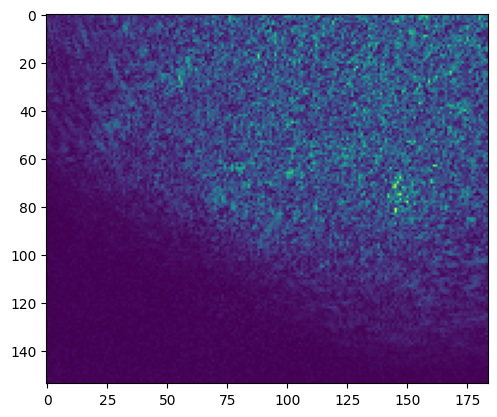

In [3]:
plt.imshow(images1[19][:,:,120])

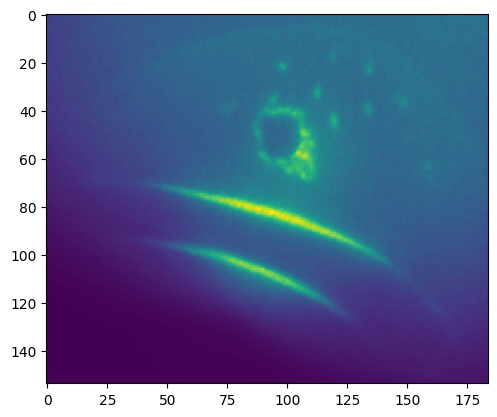

In [4]:
plt.imshow(image1[:,:,100])

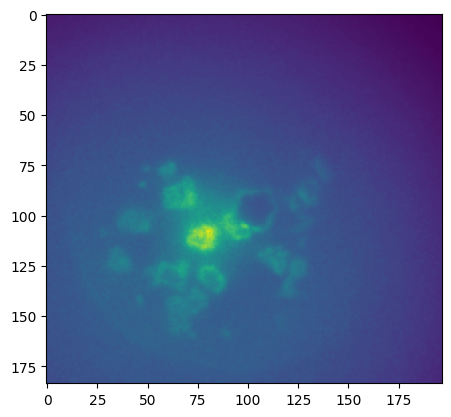

In [5]:
plt.imshow(image1[55,:,:])

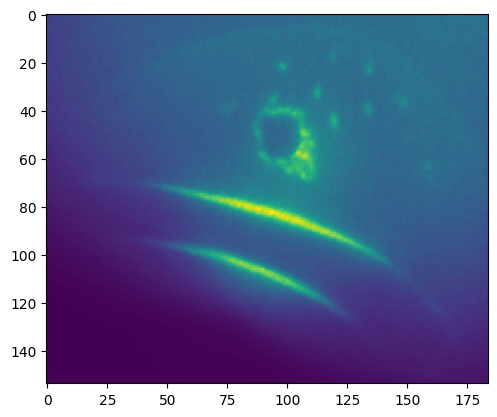

In [9]:
plt.imshow(image1[:,:,100])

In [14]:
test_experiment.sensor.sensor_coords.shape

(16384, 3)

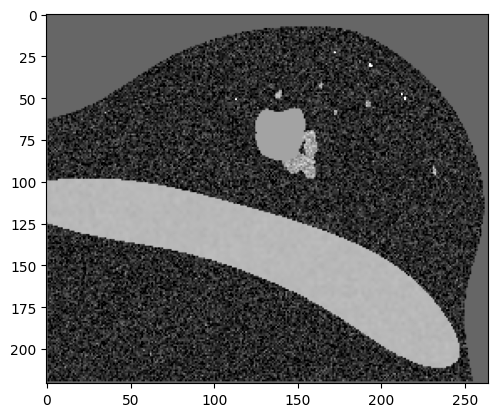

In [ ]:
plt.imshow(test[:, :, int(test.shape[2]*0.5)], cmap='gray', vmin=1400, vmax=1650)

In [2]:
# files = glob.glob('breast_3D_planewave_net/reconstruct/intermediate_image_00*.npz')
files = glob.glob('breast_synthetic_aperture_2/reconstruct/intermediate_image_00*.npz')
images1 = []
for path in tqdm.tqdm(files):
    images1.append(utils.load_array(path))
images1 = np.array(images1)

image1 = np.sum(images1, axis=0)/len(images1)

100%|██████████| 269/269 [00:26<00:00, 10.27it/s]


In [3]:
utils.save_mrc(image1, 'breast_synthetic_aperture_2.mrc')

NameError: name 'test' is not defined

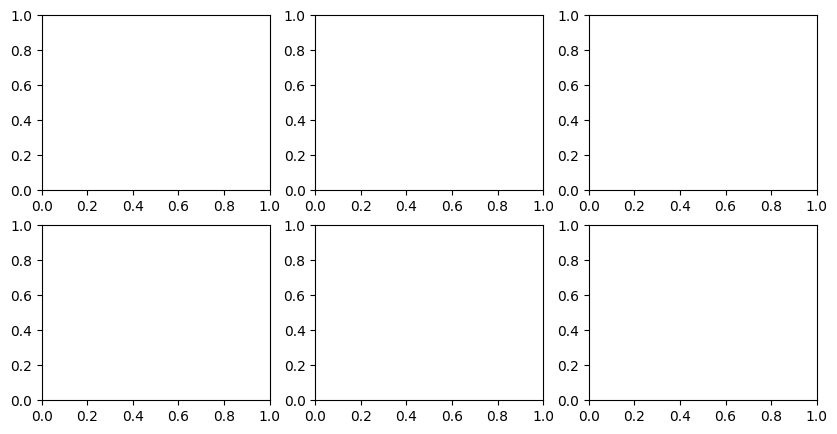

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
index = 0.5
ax[0,0].imshow(test[0,:, :, int(test.shape[3]*index)], cmap='gray', vmin=1400, vmax=1650)
ax[1,0].imshow(image1[:,:,int(image1.shape[2]*index)], cmap='gray', vmin=0, vmax=30000)
index = 0.55
ax[0,1].imshow(test[0,:, int(test.shape[2]*index), :], cmap='gray', vmin=1400, vmax=1650)
ax[1,1].imshow(image1[:, int(image1.shape[1]*index), :], cmap='gray', vmin=0, vmax=30000)
index = 0.35
ax[0,2].imshow(test[0,int(test.shape[1]*index), :, :], cmap='gray', vmin=1400, vmax=1650)
ax[1,2].imshow(image1[int(image1.shape[0]*index), :, :], cmap='gray', vmin=0, vmax=30000)